# Checking Selection

In this notebook, we check the selection of the input sample. 

In [1]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/")


In [4]:
from libs.main import copacabana
from libs.make_input_files.make_input_datasets import *

import pandas as pd
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import numpy as np
import matplotlib.pyplot as plt

In [135]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

### Loading Input Catalog

In [68]:
run='emuBPZ'

In [436]:
cfg = '../libs/config_copa_dc2.yaml'
copa = copacabana(cfg)

copa.kwargs['dmag_lim'] = 1
g, c = load_copa_input_catalog(copa.master_fname,copa.kwargs,pz_file='emuBPZ',simulation=True)

loading clusters
loading full members catalog
making color columns
selecting fake photo-z catalog
making galaxies cut
galaxy catalog
all:  50074070
cut:  12133047
assigning background galaxies
computing physical quantities


In [437]:
mask = g['Bkg']
np.count_nonzero(mask)

6616061

### Check Background

In [438]:
r_in  = copa.kwargs['r_in']
r_out = copa.kwargs['r_out']

radii = g['R']*0.7

Text(0.5,0,'R [Mpc]')

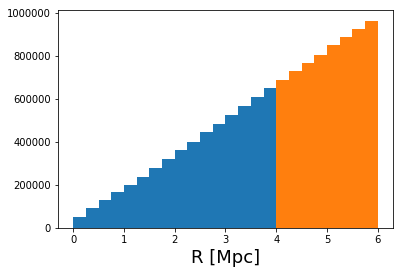

In [439]:
dr = 0.25
rbins = np.arange(0,r_out+dr,dr)

plt.hist(radii,bins=rbins)
plt.hist(radii[mask],bins=rbins)
plt.xlabel('R [Mpc]',fontsize=18)

### Select only true members

In [440]:
def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [441]:
gt = g[g['True']]

In [442]:
gcidx = gt['CID']
cidx  = c['CID']

r200  = c['R200_true']
m200  = c['M200_true']
zcls  = c['redshift']

In [443]:
keys  = list(chunks(gcidx,cidx))

### Sky Plot

In [444]:
def sky_plot(RA,DEC,title="Buzzard v1.6 - 1000 GC",savefig='./img/sky_plot.png'):
    import matplotlib.pyplot as pplot
    import astropy.coordinates as coord
    from astropy import units as u
    
    ra = coord.Angle(RA*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(DEC*u.degree)

    fig = pplot.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="aitoff")
    plt.title(title)
    ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
    ax.grid(True)
    ax.scatter(ra.radian, dec.radian, s=10, alpha=0.5)
    plt.subplots_adjust(top=0.9,bottom=0.0)
    # ax.set_xticklabels(['10h','8h','6h','4h','2h','0h','20h','18h','16h','14h','12h'])
    
    #fig.savefig(savefig, bbox_inches = "tight")
    #plt.clf()
    #plt.close()


In [445]:
ra = c['RA']
dec= c['DEC']

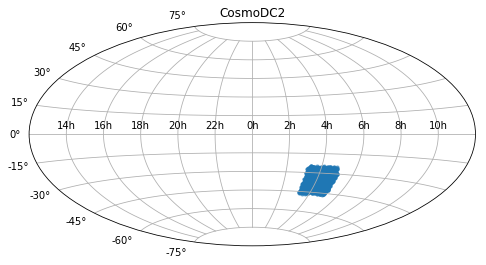

In [446]:
sky_plot(ra,dec,title='CosmoDC2')

### HOD Model

In [447]:
def compute_n200(data,r200):
    mask = data['R']<=r200
    return np.count_nonzero(mask)

In [448]:
n200 = np.array([compute_n200(gt[idx],r200[i]) for i, idx in enumerate(keys)])

Text(0.5,1,'emuBPZ')

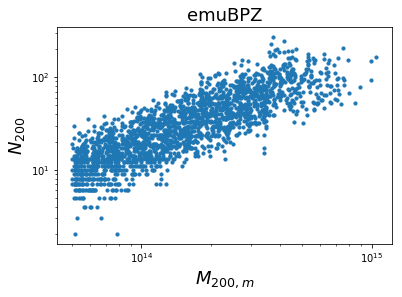

In [449]:
plt.scatter(m200,n200,s=10)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$N_{200}$',fontsize=18)
plt.xlabel(r'$M_{200,m}$',fontsize=18)
plt.title(run,fontsize=18)

In [450]:
np.log10(1/0.7)

0.15490195998574316

### Magnitude Model

In [476]:
idx = g['True']

In [477]:
amag= g['Mr'][idx]
mag = g['mag'][idx]
zcls= g['redshift'][idx]
dmag= g['dmag'][idx]

Text(0.5,1,'Only True Members')

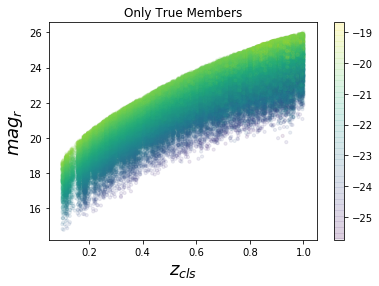

In [478]:
plt.scatter(zcls,mag[:,1],c=amag,s=10,alpha=0.1)
plt.colorbar()
plt.xlabel(r'$z_{cls}$',fontsize=18)
plt.ylabel(r'$mag_{r}$',fontsize=18)
plt.title('Only True Members')

Text(0.5,1,'Only True Members')

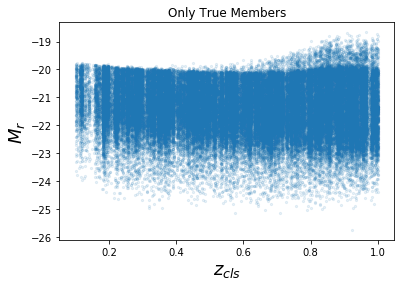

In [481]:
plt.scatter(zcls,amag,s=5,alpha=0.1)
plt.ylabel(r'$M_{r}$',fontsize=18)
plt.xlabel(r'$z_{cls}$',fontsize=18)
plt.title('Only True Members')

In [570]:
np.count_nonzero(idx)

90637

### Photoz Properties

In [569]:
idx = g['True']

In [483]:
zt   = g['z_true'][idx]
zp   = g['z'][idx]
zerr = g['zerr'][idx]

zoff = g['zoffset'][idx]
pz0  = g['pz0'][idx]
zcls = g['redshift'][idx]

In [484]:
zvec = np.linspace(0.01,3,40)
xmin,xmax=0.0,1.1
def identity(ztru,z,xmin=0.,xmax=2.,ax=None):
    if ax is None: ax=plt.axes()
    ax.plot(zvec,zvec,ls='--',color='k')
    ax.scatter(ztru,z,color=blue,alpha=0.05,s=10,label='true members')
    ax.axhline(1.,color='k')
    ax.axvline(1.,color='k')
    ax.set_xlabel(r'$z_{true}$',fontsize=18)
    ax.set_ylabel(r'$z_{ph}$',fontsize=18)
    ax.set_ylim(xmin,xmax)
    ax.set_xlim(xmin,xmax)

Text(0.5,1,'Only True Members')

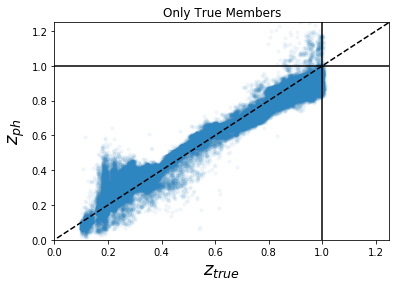

In [485]:
identity(zt,zp,xmax=1.25)
plt.title('Only True Members')

In [486]:
def plot_pannel(x,y,z,indices,labels,nx=2,ny=4,xlims=(-0.3,0.3),ylims=(-0.3,0.3),ylb=r'$p_{z,0}$',xlb='z'):
    fig = plt.figure(figsize=(5*ny,4*nx))
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
    nplots = int(nx*ny)
    
    cmin,cmax = np.nanpercentile(z,10), np.nanpercentile(z,90)
    for i in range(nplots):
        idx= indices[i]
        ax = plt.subplot(nx, ny, i+1)
        im = ax.scatter(x[idx], y[idx],c=z[idx],label=labels[i],s=10,alpha=0.5,vmin=cmin,vmax=cmax)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.legend()
        
        xc = x[idx]
        ax.axvline(np.median(xc[y[idx]>0.]),ls='--',lw=2,color='k')
        
        if (i+1)%ny == 0:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04,label='$z_{err}$')
        
        if i>=(nx-1)*ny:
            ax.set_xlabel(xlb,fontsize=18)
        
        if ((i)%ny)!=0:
            ax.set_yticks([])
        else:
            ax.set_ylabel(ylb,fontsize=18)
        

In [487]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins


In [488]:
dz     = 0.015
zbins  = np.arange(0.1,1.+dz,dz)
cut    = np.array([i+3 for i in range(len(zbins[:-3]))])

keys,zb= makeBins(zcls,zbins[::4])

zbase  = '%.2f < z < %.2f' 
labels = [zbase%(zm-dz/2,zm+dz/2) for zm in zb]

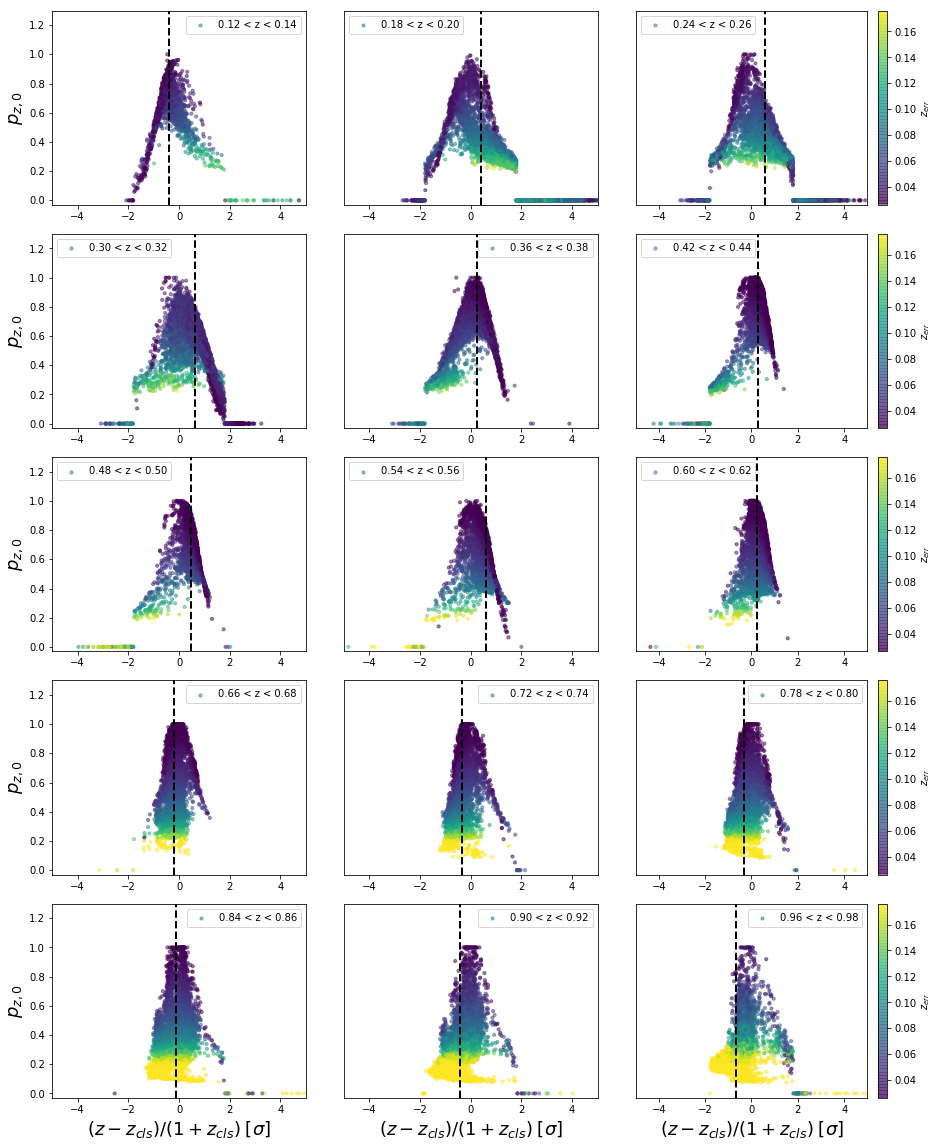

In [489]:
lb=r'$(z-z_{cls})/(1+z_{cls}) \; [\sigma] $'
plot_pannel(zoff/0.05,pz0,zerr,keys,labels,ylims=(-0.03,1.3),xlims=(-5,5),nx=5,ny=3,xlb=lb)

In [490]:
def compute_outlier_fraction(pz,th=0.01):
    return 1.*np.count_nonzero(pz<th)/len(pz)

In [659]:
dz     = 0.015
zbins  = np.arange(0.1-dz/2,1.+dz/2,dz)
keys,zb= makeBins(zcls,zbins)

ofrac = np.array([compute_outlier_fraction(pz0[idx]) for idx in keys])

Text(0.5,1,'CosmoDC2 - emuBPZ')

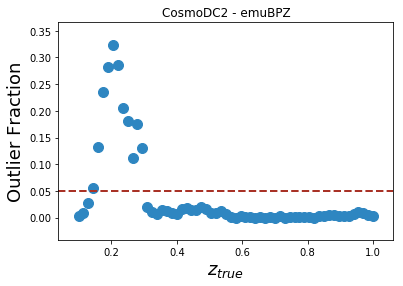

In [661]:
plt.scatter(zb,ofrac,s=100,color=blue)
plt.axhline(0.05,ls='--',lw=2,color=red)
plt.xlabel(r'$z_{true}$',fontsize=18)
plt.ylabel(r'Outlier Fraction',fontsize=18)
plt.title('CosmoDC2 - emuBPZ')

In [652]:
def remove_outliers(x):
    q25,q75 = np.nanpercentile(x,[25,75])
    iqr     = q75-q25
    lo, up  = q25-1.5*iqr, q75+1.5*iqr
    
#     print('lower limit: %.3f'%(lo))
#     print('upper limit: %.3f'%(up))
    
    mask    = (x<up)&(x>lo)
    return mask

In [662]:
# importing library
from scipy.stats import skewnorm 
import scipy.stats as stats

In [663]:
def fit_gauss(z):
    mask = remove_outliers(z)
    zfit = z[mask]
    res  = np.array([np.nanmean(zfit),np.nanstd(zfit),1-1.*np.count_nonzero(mask)/len(z)])
    return res
res  = np.array([fit_gauss(zoff[idx]) for i,idx in enumerate(keys)])
bias = res[:,0]
sigma= res[:,1]
of   = res[:,2]

In [664]:
def fit_skew(zfit,zcut=0.2):
    mask = remove_outliers(zfit)
    zfit = zfit[mask]
    res = skewnorm.fit(zfit)
    return np.array(res)

res  = np.array([fit_skew(zoff[idx],zcut=0.15) for i,idx in enumerate(keys)])
alpha  = res[:,0]
bias1  = res[:,1]
sigma1 = res[:,2]

In [665]:
w, = np.where(np.abs(alpha))

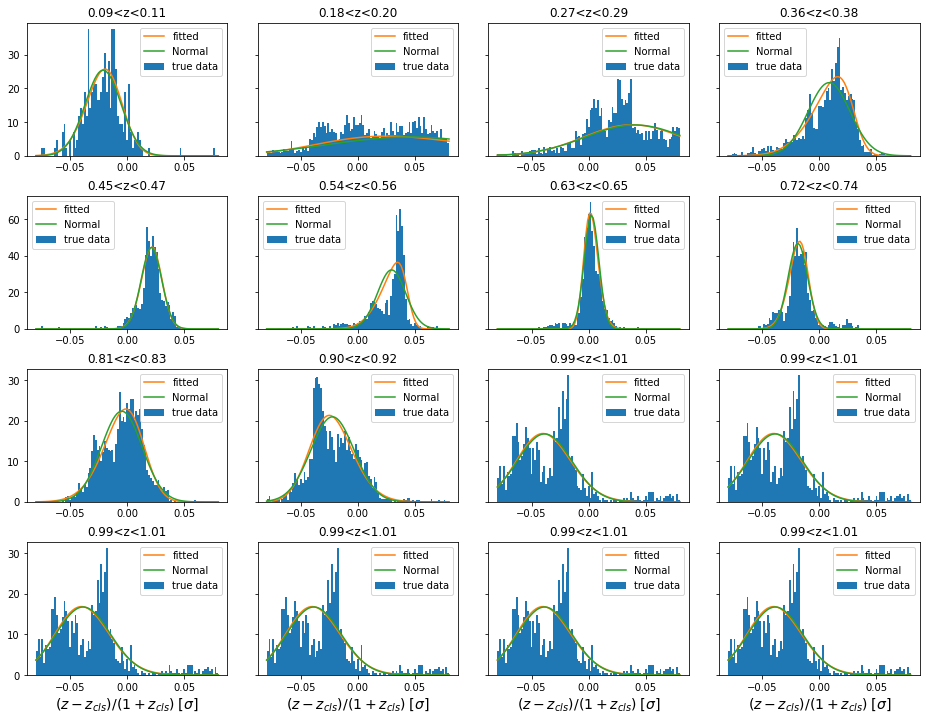

In [666]:
fig, axs = plt.subplots(4, 4, sharey='row', sharex='row', figsize=(16,12))
fig.subplots_adjust(hspace=0.3,wspace=0.15)

axs = axs.flatten()

mybins=np.linspace(-0.08,.08,100)
for i in range(16):
    ii=int(6*i)
    if ii>=len(keys):
        ii = len(keys)-1
    ix = keys[ii]
    ax = axs[i]
    _ = ax.hist(zoff[ix],bins=mybins,density=True,label='true data')
    ax.set_title('%.2f<z<%.2f'%(zbins[ii],zbins[ii+1]))
#     ax.set_yscale('log')
    if i>11:
        ax.set_xlabel(lb,fontsize=14)
    
    zfit = zoff[ix][np.abs(zoff[ix])<0.22]
    ae, loce, scalee = alpha[ii],bias1[ii],sigma1[ii]
    pn = stats.norm.pdf(mybins,loc=bias[ii],scale=sigma[ii])
    p = skewnorm.pdf(mybins, ae,loc=loce,scale=scalee)
    #p = skew_norm_pdf(mybins,0,std,0.)
    ax.plot(mybins,p,label='fitted')
    ax.plot(mybins,pn,label='Normal')
    ax.legend()
    

(0.0, 0.08)

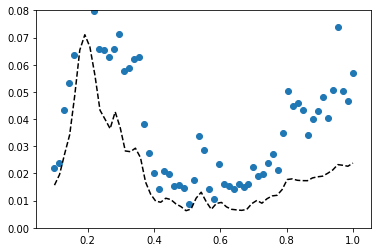

In [678]:
zv = np.linspace(0.1,1.,60)
plt.plot(zv,np.interp(zv,zb,sigma),'k--')
plt.scatter(zb,sigma1*(1+zb))
plt.ylim(0.,0.08)

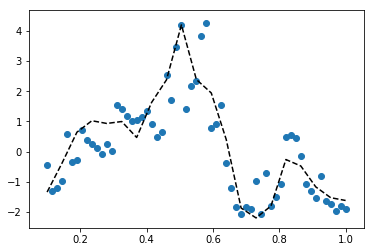

In [683]:
zv = np.linspace(0.1,1.,21)
plt.plot(zv,np.interp(zv,zb,bias/sigma),'k--')
plt.scatter(zb,bias1/sigma1)

# plt.xlim(0.08,0.6)

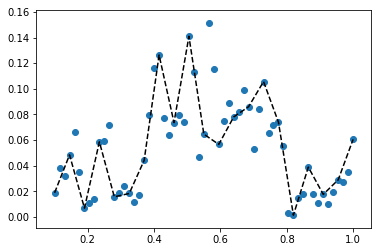

In [685]:
zv = np.linspace(0.1,1.,21)
plt.plot(zv,np.interp(zv,zb,of),'k--')
plt.scatter(zb,of)

In [672]:
outfile  = 'zwindow_model_emuBPZ.txt'
savefile = open(outfile, "w")

with open(outfile, "w") as savefile:
    header = '#z,bias,sigma,outlier_frac\n'
    savefile.write(header)
    for i in range(len(zb)):
        line = '%.3f,%.3f,%.3f,%.3f\n'%(zb[i],bias[i],sigma[i],of[i])
        savefile.write(line)

savefile.close()